# From XML to CSV

In [1]:
import os
import xmltodict
import pandas as pd
import matplotlib.pyplot as plt
from community import community_louvain
import networkx as nx
from netgraph import Graph
import numpy as np
def flatten_json(y):
    out = {}
    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '.')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '.')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(y)
    return out

df_list = []
for file in os.listdir("../re3data/repo_md/"):
    json_doc = xmltodict.parse(open("../re3data/repo_md/"+file,"r").read())

    # Driver code
    dictio=flatten_json(json_doc)
    # open("test.json","w").write(json.dumps(flatten_json(json_doc), indent=4))
    df_list.append(pd.DataFrame.from_dict(dictio, orient="index").transpose())



data_df = pd.concat(df_list)
data_df.to_csv("results_repository_MD.csv", index=False)


# Data selection

In [2]:
data_selection = data_df.filter(regex="repositoryName.*text|repositoryIdentifier|subject.*text|apiType|keyword|metadataStandardName.*text")
data_selection.to_csv("data_selection.csv", index=False)


# Data cleaning

In [58]:
keywords = data_selection.filter(regex="keyword").transpose().apply(lambda x : '#'.join(x.dropna().astype(str)))
subject = data_selection.filter(regex="subject.*text").transpose().apply(lambda x : '#'.join(x.dropna().astype(str)))
API = data_selection.filter(regex="apiType").transpose().apply(lambda x : '#'.join(x.dropna().astype(str)))
MD_standards = data_selection.filter(regex="metadataStandardName.*text").transpose().apply(lambda x : '#'.join(x.dropna().astype(str)))
id = data_selection.filter(regex="repositoryIdentifier").transpose().apply(lambda x : '#'.join(x.dropna().astype(str)))
name = data_selection.filter(regex="repositoryName.*text")


cleaned_df = pd.concat([name,id,subject,keywords,API, MD_standards],axis=1)
column_name = ["name","id","subject","keywords","API_type","MD_standards"]
rename_dict = {}
for old_name,new_name in zip(cleaned_df.columns,column_name):
    rename_dict[old_name]=new_name
# print(rename_dict)
cleaned_df = cleaned_df.rename(rename_dict,axis=1)
cleaned_df.to_csv("data_selection_cleaned.csv", index=False)



In [59]:
len(cleaned_df)

3117

# Edges creation

In [4]:
repo_data = cleaned_df

repo_no_na = repo_data.dropna(subset=["API_type","MD_standards"])

# List of platform that implements API then MD_standards
# Any platform in a same list is interoperable with other
node_edges = {}


unique_api_type = set(repo_no_na["API_type"].map(lambda x : x.split("#")).sum())
unique_api_type.remove('')
for API in unique_api_type:
    print(API)
    node_edges[API] = {}

    unique_MD = set(repo_no_na[repo_no_na["API_type"].map(lambda x : API in x)]["MD_standards"].map(lambda x : x.split("#")).sum())
    for MD in unique_MD:

        node_edges[API][MD]=list(pd.merge(repo_no_na[repo_no_na["MD_standards"].map(lambda x: x.split("#")).map(lambda x : bool(len(set(x).intersection(set([MD])))>0 ))],repo_no_na[repo_no_na["API_type"].map(lambda x : x.split("#")).map(lambda x : bool(set(x) & set([API])) )])["name"])


OpenDAP
OAI-PMH
SOAP
SWORD
REST
FTP
NetCDF
other
SPARQL


In [5]:
node_edges.keys()

dict_keys(['SPARQL', 'NetCDF', 'other', 'REST', 'FTP', 'SOAP', 'OAI-PMH', 'SWORD', 'OpenDAP'])

# Every edges - every nodes - every protocol : Interoperability of platforms

In [6]:
from itertools import combinations
import random
couple_node_data_analysis = []

for API in node_edges:
    for MD in node_edges[API]:
        # if MD != "Dublin Core":
            couple_node_data_analysis += list(set([tuple(sorted(x)) for x in combinations(node_edges[API][MD],2)]))
        # for i in range(len(node_edges[API][MD])):
        #     couple_node.append((node_edges[API][MD][i], node_edges[API][MD][(i+1)%len(node_edges[API][MD])]))
        #     couple_node.append((node_edges[API][MD][i], node_edges[API][MD][(i+5)%len(node_edges[API][MD])] ))
            # Exchange uncommented line with this one to get every edges
            # couple_node.append((MD+"-OAI-PMH",node_edges["OAI-PMH"][MD][i]))


In [8]:
len(couple_node_data_analysis)

156455

In [9]:
node_edges

{'SWORD': {'': ['Columbia University Academic Commons',
   'DOE Joint Genome Institute Genome  Portal',
   'IDEALS',
   'The Dataweb Dataverse'],
  'PROV': ['TROLLing', 'DataverseNO'],
  'ABCD - Access to Biological Collection Data': ['LibraData'],
  'other': ['Abacus Data Network', 'Repository for Open Data (RepOD)'],
  'DataCite Metadata Schema': ["Queen's University Dataverse",
   'UCLA Dataverse',
   'McGill University Dataverse',
   'Concordia University Dataverse',
   'Dados Abertos De Pesquisas',
   'ASU Library Research Data Repository',
   "Dataverse de l'Institut national de la recherche scientifique",
   'RIN Data Repository',
   'Université de Montréal – Dataverse',
   'Mount Royal University Dataverse',
   'McMaster University Dataverse',
   'Prospered Project',
   'Arca Dados',
   'ARP Research Data Repository',
   'e-cienciaDatos',
   'Wilfrid Laurier University Dataverse',
   'George Mason University Dataverse',
   'University of Waterloo Dataverse',
   'Social Data Rep

In [10]:

G = nx.Graph()

# import igraph as ig
G.add_nodes_from(list(repo_data["name"].values))
for i in [MD for MD in node_edges["OAI-PMH"]]:
    G.add_node(i, color="green")
G.add_edges_from(couple_node_data_analysis)

In [11]:
print(str(len(G.nodes)) + " nodes / " + str(len(G.edges)) + " edges")
print("Duplicate edges are merged in an unique edge")

3140 nodes / 133654 edges
Duplicate edges are merged in an unique edge


## Density of the graph : all nodes all edges

In [12]:
nx.density(G)

0.027120081652033286

## Mean degree in the graph : all nodes all edges

In [13]:
np.mean([d for _, d in G.degree()])

85.12993630573249

<Axes: ylabel='Frequency'>

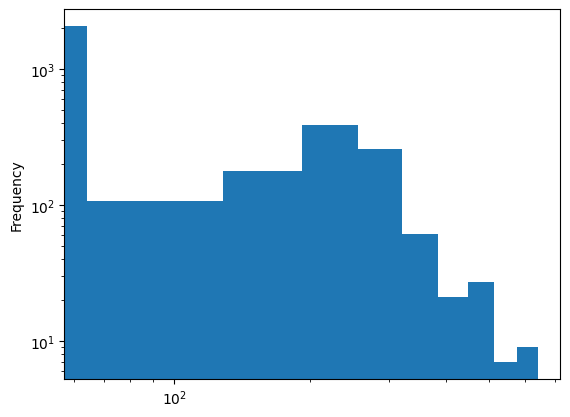

In [14]:
import matplotlib.pyplot as plt

# plt.hist(pd.Series([d for _, d in G.degree()]), log=True)

pd.Series([d for _, d in G.degree()]).plot(kind="hist", logx=True, logy=True)


## Removing unconnected nodes

In [15]:
isolated_nodes = list(nx.isolates(G))
print(len(isolated_nodes))

1731


In [16]:
G.remove_nodes_from(isolated_nodes)


In [17]:
print(str(len(G.nodes)) + " nodes / " + str(len(G.edges)) + " edges")


1409 nodes / 133654 edges


# Density without isolated nodes

In [18]:
nx.density(G)

0.13474054777727595

# Mean degree without isolated nodes

In [19]:
np.mean([d for _, d in G.degree()])

189.71469127040453

# Selecting data only on OAI-PMH : Knowledge sharing in Open Science

In [5]:
from itertools import combinations
import random
couple_node = []

# for API in node_edges:
for MD in node_edges["OAI-PMH"]:
    # if MD != "Dublin Core":
        couple_node += list(set([tuple(sorted(x)) for x in combinations(node_edges["OAI-PMH"][MD],2)]))
    # for i in range(len(node_edges["OAI-PMH"][MD])):
        # couple_node.append((node_edges["OAI-PMH"][MD][i], node_edges["OAI-PMH"][MD][(i+1)%len(node_edges["OAI-PMH"][MD])]))
        # couple_node.append((node_edges["OAI-PMH"][MD][i], node_edges["OAI-PMH"][MD][(i+5)%len(node_edges["OAI-PMH"][MD])] ))
        # Exchange uncommented line with this one to get every edges
        # couple_node.append((MD+"-OAI-PMH",node_edges["OAI-PMH"][MD][i]))


# Graph creation : only on OAI-PMH

In [ ]:

G_OAI = nx.Graph()

# import igraph as ig
G_OAI.add_nodes_from(list(repo_data["name"].values))
# Change color of node for OAI-PMH
for i in [MD+"-OAI-PMH" for MD in node_edges["OAI-PMH"]]:
    G_OAI.add_node(i, color="green")
G_OAI.add_edges_from(couple_node)

In [37]:
print(str(len(G_OAI.nodes)) + " nodes / " + str(len(G_OAI.edges)) + " edges")


3140 nodes / 22179 edges


# Graph density : only on OAI-PMH (knowledge sharing)

In [38]:
nx.density(G_OAI)

0.004500398723273873

# Mean degree :  only on OAI-PMH (knowledge sharing)
Used in section 3.3 to get the probability to have the researched information (14.23 + 1)

In [39]:
np.mean([d for _, d in G_OAI.degree()])

14.126751592356689

# Community clustering : Louvain method

In [40]:
node_to_community = community_louvain.best_partition(G_OAI)


# Plotting graph

In [ ]:


couple_node = []

# Reducing number of edge for plotting ; communities already computed
for MD in node_edges["OAI-PMH"]:
    # if MD != "Dublin Core":
    #     couple_node += list(set([tuple(sorted(x)) for x in combinations(node_edges["OAI-PMH"][MD],2)]))
    for i in range(len(node_edges["OAI-PMH"][MD])):
        couple_node.append((node_edges["OAI-PMH"][MD][i], node_edges["OAI-PMH"][MD][(i+1)%len(node_edges["OAI-PMH"][MD])]))
        if len(node_edges["OAI-PMH"][MD]) > 1:
            couple_node.append((node_edges["OAI-PMH"][MD][i], node_edges["OAI-PMH"][MD][(i+5)%len(node_edges["OAI-PMH"][MD])] ))
        # Exchange uncommented line with this one to get every edges
        # couple_node.append((MD+"-OAI-PMH",node_edges["OAI-PMH"][MD][i]))

G_OAI = nx.Graph()

G_OAI.add_nodes_from(list(repo_data["name"].values))
# Change color of node for OAI-PMH
for i in [MD+"-OAI-PMH" for MD in node_edges["OAI-PMH"]]:
    G_OAI.add_node(i)
G_OAI.add_edges_from(couple_node)

print(nx.density(G_OAI))
fig = plt.figure(figsize=(18,18))
g=G_OAI
res = {}
for i in node_to_community:
    if node_to_community[i] in res :
        res[node_to_community[i]] += 1
    else:
        res[node_to_community[i]] = 1
print(node_to_community)
print(res)
communities_unique = []
for key in res :
    if res[key]!=1:
        communities_unique.append(key)

print(communities_unique)
# 
change = {}
commu_aux_change_number = 0
for i in communities_unique:
    print(i)
    change[i] = commu_aux_change_number
    commu_aux_change_number+=1

for i in node_to_community:
    if node_to_community[i] not in communities_unique:
        node_to_community[i]=7
    else :
        node_to_community[i]=change[node_to_community[i]]

community_to_color = {
    0 : 'tab:blue',
    1 : 'tab:orange',
    2 : 'tab:green',
    3 : 'tab:red',
    4 : 'tab:purple',
    5 : 'tab:brown',
    6 : 'tab:pink',
    7 : 'tab:gray',
    8 : 'tab:olive',
    9 : 'tab:cyan'
}
aux = {key : index for index,key in enumerate(communities_unique) }
node_color = { node :(community_to_color[aux[community_id]] if community_id in communities_unique else community_to_color[7]) for node, community_id in node_to_community.items() }

Graph(g,
      node_color=node_color, node_edge_width=0.1, edge_width=0.01,
        node_layout="community", node_layout_kwargs=dict(node_to_community=node_to_community),
      edge_layout='bundled', node_size=0.3
)
plt.savefig("community_OAI_PMH_allnode.pdf")
plt.show()

0.0001720698912185511
{'World Data Center for Geomagnetism, Kyoto': 0, 'Maharashtra State Data Bank': 0, 'DTU Data': 1, 'Biological Collection Access Service for Europe': 0, 'mzCloud': 0, 'AgroSpace': 0, 'IZTECH GCRIS': 1, 'climate4impact': 0, 'National Center for Ecological Analysis and Synthesis Data Repository': 0, 'PSnpBind': 0, 'Goddard Earth Sciences Data and Information Services Center': 0, 'Données Québec': 0, 'Hazardous Substance Data Bank': 0, 'Life Science Database Archive': 0, 'FAIRDOMHub': 0, 'Pacific Climate Impacts Consortium Data Portal': 0, 'Jean Paul – Sämtliche Briefe digital': 0, 'RESA': 0, 'UdS Fedora Commons Repository': 1, 'Ontario Reptile and Amphibian Atlas': 0, "Queen's University Dataverse": 0, 'European Election Database': 0, 'Canadian Disaster Database': 0, 'GLUES Geoportal': 0, 'Scripps Institute of Oceanography Explorer': 0, 'GabiPD': 0, 'Netherlands Trial Register': 0, 'Forschungsdatenzentrum der Bundesagentur für Arbeit im Institut für Arbeitsmarkt und 

/home/vdang/PycharmProjects/EDBT_paper/venv/lib/python3.8/site-packages/netgraph/_node_layout.py:1549: UserWarning: Graph contains a single community. Unable to compute a community layout. Computing spring layout instead.
  warnings.warn("Graph contains a single community. Unable to compute a community layout. Computing spring layout instead.")
/home/vdang/PycharmProjects/EDBT_paper/venv/lib/python3.8/site-packages/netgraph/_node_layout.py:1023: RuntimeWarning: invalid value encountered in divide
  directions = deltas / magnitudes[:, np.newaxis]


## Removing isolated nodes : only on OAI-PMH (knowledge sharing)

In [29]:
isolated_nodes = list(nx.isolates(G_OAI))
print(len(isolated_nodes))

2826


In [110]:
G_OAI.remove_nodes_from(isolated_nodes)
print(str(len(G_OAI.nodes)) + " nodes / " + str(len(G_OAI.edges)) + " edges")


290 nodes / 22179 edges


# Graph density without isolated nodes

In [113]:
nx.density(G_OAI)

0.529268583701229

# Mean degree without isolated nodes

In [121]:
np.mean([d for _, d in G_OAI.degree()])

152.95862068965516

# Data viz (same but different plotting tool)
## Plotting

                     name                id  \
count                3117              1144   
unique               3116              1144   
top     EarthChem Library  biodbcore-001753   
freq                    2                 1   

                                                  subject           keywords  \
count                                                3112               3108   
unique                                               1542               2796   
top     1 Humanities and Social Sciences#2 Life Scienc...  multidisciplinary   
freq                                                  324                255   

       API_type MD_standards  
count      1416         1267  
unique      116          171  
top        REST  Dublin Core  
freq        348          192  
Graph nodes : 
3117
Graph edges : 
22179
Unconnected nodes :
2827
Graph density :
0.004567070390829535


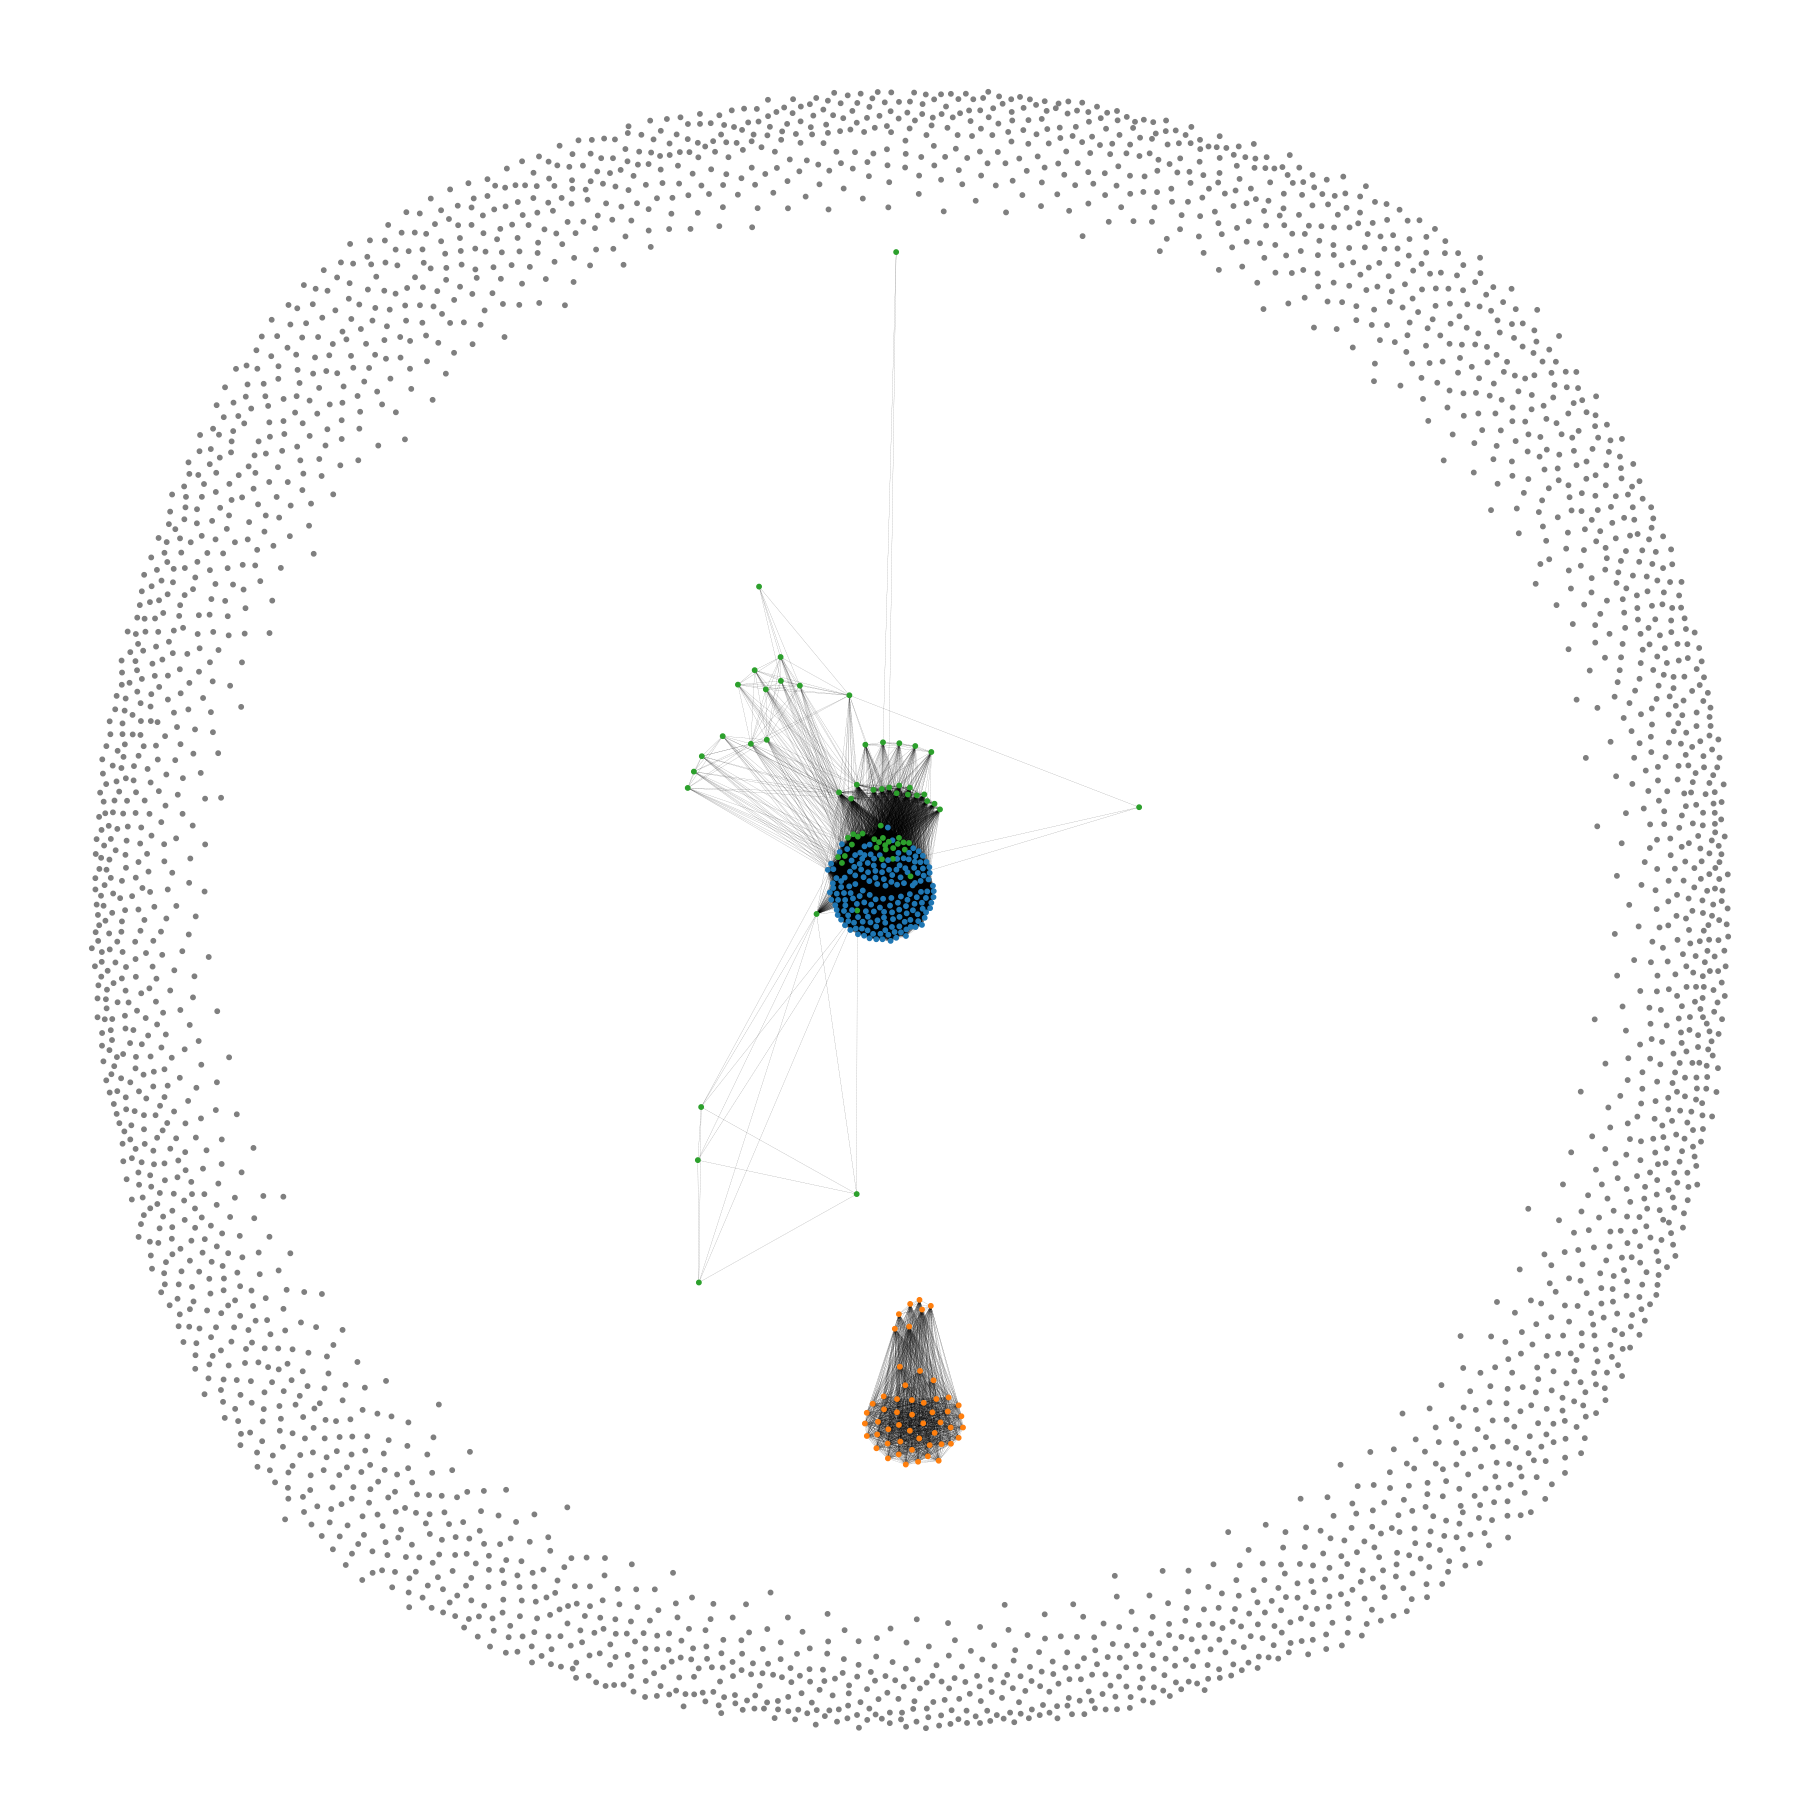

In [77]:
from itertools import combinations

data = pd.read_csv("data_selection_cleaned.csv")

print(data.describe())

G= nx.Graph()
couple_node = []

for API in node_edges:
    for MD in node_edges["OAI-PMH"]:
            couple_node += list(set([tuple(sorted(x)) for x in combinations(node_edges["OAI-PMH"][MD],2)]))



G.add_nodes_from(list(data["name"].values))
G.add_edges_from(couple_node, weight=0.01)

# EarthChem Library is defined 2 times but are merged as a single platform
# This line is to add back this second EarthChem Library
G.add_node("EarthChem Library2", color=node_color[i])
print("Graph nodes : ")
print(len(G.nodes))
print("Graph edges : ")
print(len(G.edges))
print("Unconnected nodes :")
print(len(list(nx.isolates(G))))

node_to_community = community_louvain.best_partition(G)
print("Graph density :")
print(nx.density(G))
# installation easiest via pip:
# pip install netgraph
fig = plt.figure(figsize=(18,18))

res = {}
for i in node_to_community:
    if node_to_community[i] in res :
        res[node_to_community[i]] += 1
    else:
        res[node_to_community[i]] = 1

communities_unique = []
for key in res :
    if res[key]!=1:
        communities_unique.append(key)


for i in node_to_community:
    if node_to_community[i] not in communities_unique:
        node_to_community[i]=7


community_to_color = {
    0 : 'tab:blue',
    1 : 'tab:orange',
    2 : 'tab:green',
    3 : 'tab:red',
    4 : 'tab:purple',
    5 : 'tab:brown',
    6 : 'tab:pink',
    7 : 'tab:gray',
    8 : 'tab:olive',
    9 : 'tab:cyan'
}
aux = {key : index for index,key in enumerate(communities_unique) }
node_color = { node :(community_to_color[aux[community_id]] if community_id in communities_unique else community_to_color[7]) for node, community_id in node_to_community.items() }

list_colors = []
for i in node_color:
    list_colors.append(node_color[i])

nx.draw(G, node_color=list_colors, node_size=10, pos=nx.spring_layout(G,k=0.05), style="dashed", width=0.1)
# nx.draw(G, node_color=list_colors, node_size=10)
plt.savefig("path.pdf", format="pdf")
plt.savefig("path.png", format="png")


In [262]:
df_vol = pd.read_csv("results_repository_MD.csv",header=0, low_memory=False)["r3d:re3data.r3d:repository.r3d:size.#text"].dropna()

df_vol[df_vol.map(lambda x : "dataset" in x )]

2                               641 results; 509 datasets
6                                              3 datasets
10                                         1.428 datasets
11                                         1.246 datasets
20               19 dataverses; 146 datasets: 4.512 files
                              ...                        
3063                        13 dataverses; 3.050 datasets
3072                                          65 datasets
3089    32.167 datasets; 15.142 maps; 1.146 galleries;...
3098                           4.217 results; 55 datasets
3115                                         217 datasets
Name: r3d:re3data.r3d:repository.r3d:size.#text, Length: 454, dtype: object

In [259]:

df_vol[df_vol.map(lambda x : "sample" in x )]

34      1.832 rokaryotic genomes; 996.747 16S/18S rRNA...
42      9.641 human samples; 900 mouse samples; 828.35...
100     over 20.000 meters of deep-sea core sediment a...
252                             52000 samples, 50 species
267     sample of more than 12,000 persons of the thre...
347     8 Germplasm; 13 biological sample; 8 animal mo...
361                                         2.155 samples
448     8.534 Unoriented High Resolution Raman Spectra...
676     33.543 studies; 53.160 biosamples; 235.292 seq...
751                     1.250 samples; 2.418 measurements
794     515 biobanks with over 60 million biological s...
1046     3.692 studies; 215.970 samples; 280.606 analyses
1121    69 standard, non-diseased samples as well as t...
1201    4.901 projects; 735.895 samples submitted by 4...
1439                               over 3 million samples
1674                             more than 30.000 samples
1730    2.183.180 analyses; 614.620 samples; 20.430 pa...
1968    331.35